In [173]:
!cd ikfast && python setup.py && cd ..

Traceback (most recent call last):
  File "/home/shervin/Desktop/AI for Robotics Project/AIR-Project/ikfast/setup.py", line 6, in <module>
    from compile import compile_ikfast
  File "/home/shervin/Desktop/AI for Robotics Project/AIR-Project/ikfast/compile.py", line 5, in <module>
    from distutils.core import setup
ModuleNotFoundError: No module named 'distutils'


""

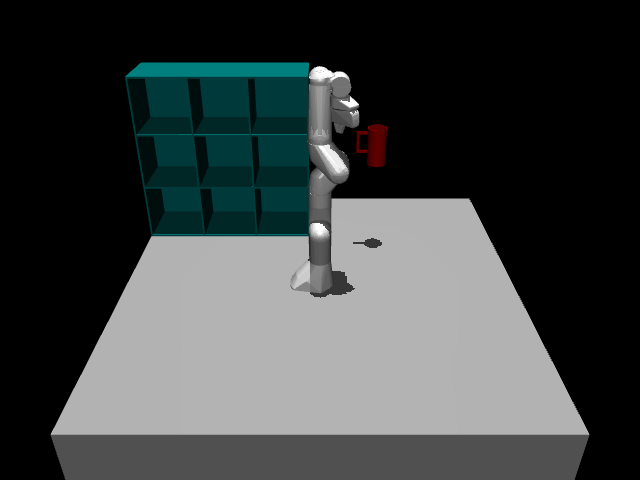

[0.3 0.4 0.5]
[7.96326711e-04 0.00000000e+00 0.00000000e+00 9.99999683e-01]
[0.24952194]


In [237]:
import numpy as np
import mujoco
import mediapy as media
import os
import glfw
import sys
sys.path.append('ikfast')
from ikfast import ikfast_panda_arm as ikfast


def has_valid_renderer():
    """Checks if OpenGL can be initialized successfully."""
    # Try initializing GLFW
    if not glfw.init():
        print("GLFW initialization failed. No valid renderer.")
        return False
    
    # Try creating a hidden window to test OpenGL context creation
    window = glfw.create_window(640, 480, "Renderer Test", None, None)
    if not window:
        print("GLFW could not create an OpenGL context. No valid renderer.")
        glfw.terminate()
        return False
    
    glfw.make_context_current(window)
    renderer_available = True  # If we reach this point, rendering should work

    # Cleanup
    glfw.destroy_window(window)
    glfw.terminate()
    return renderer_available

def render_state(model, data):
    if not has_valid_renderer():
        print("Error rendering the scene. Make sure you have a valid OpenGL installation.")
        return

    mujoco.mj_forward(model, data)
    with mujoco.Renderer(model, height=480, width=640) as renderer:
        renderer.update_scene(data, "front_view")  # Ensure scene is updated with final simulation state
        media.show_image(renderer.render())

def set_joint_positions(model, data, joints):
    data.qpos[7:14] = joints
    # data.qpos[14:16] = [0.04, 0.04]

# def set_mug_position(model, data, position):
    # data.qpos[16:19] = position
def set_mug_position(model, data, position):
    mug_qpos_addr = 16
    data.qpos[mug_qpos_addr:mug_qpos_addr+3] = position
    # data.qpos[mug_qpos_addr+3:mug_qpos_addr+7] = quaternion


    
# Define the MJCF path and mesh directory
mjcf_path = 'assets/Panda/panda.mjcf'
mesh_dir = 'assets/Panda/meshes/collision/'

# Load mesh files into a dictionary
assets = {}
for file_name in os.listdir(mesh_dir):
    file_path = os.path.join(mesh_dir, file_name)
    with open(file_path, 'rb') as f:
        assets[f'meshes/collision/{file_name}'] = f.read()

# Load the MuJoCo model
model = mujoco.MjModel.from_xml_path(mjcf_path, assets=assets)
data = mujoco.MjData(model)

# Call mj_forward to initialize the state
mujoco.mj_forward(model, data)

# Render the scene
render_state(model, data)

print(model.body("mug1").pos)
print(model.body("mug1").quat)
print(model.body("mug1").mass)

""

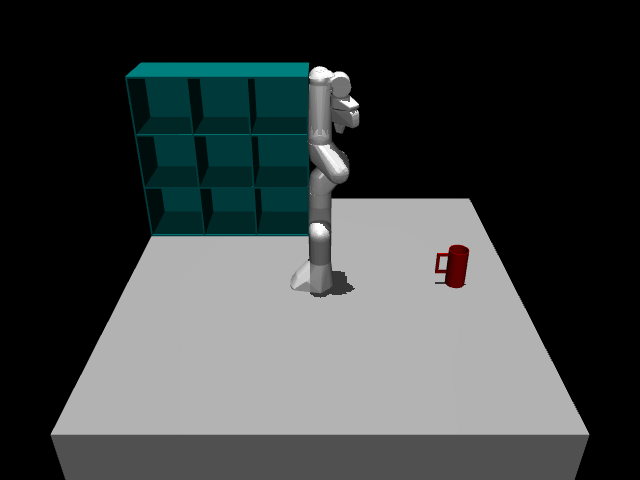

[0.7 0.  0. ]
[7.96326711e-04 0.00000000e+00 0.00000000e+00 9.99999683e-01]


In [238]:
# generating random positions for the mug

# Randomly generate a position for the mug within the specified range
# x_mug_init = np.random.uniform(0.3, 0.9)
# y_mug_init = np.random.uniform(-0.3, 0.3)
# z_mug_init = 0
# set_mug_position(model, data, [x_mug_init, y_mug_init, z_mug_init])
##########################################################

set_mug_position(model, data, [0.7, 0, 0])

#########################################################
render_state(model, data)
mug_body_id = model.body("mug1").id
print(data.xpos[mug_body_id])   # Actual position
print(data.xquat[mug_body_id])  # Actual orientation (quaternion)

In [242]:
def panda_ik_31(R_G, p_G, model, max_iters=1000):
    """ Assume that R_G and p_G are the rotation matrix and position vector of the 
    end effector in the world frame, expressed as the list objects expected by ikfast.get_ik
    """
    joint_ids = [mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_JOINT, f"panda_joint{i}") for i in range(1, 8)]
    free_joint_min = model.jnt_range[joint_ids[6], 0]
    free_joint_max = model.jnt_range[joint_ids[6], 1]
    for _ in range(max_iters):
        free_joint = [np.random.uniform(free_joint_min, free_joint_max)]
        # print(free_joint)
        ik_solutions = ikfast.get_ik(R_G, p_G, free_joint)
        # Check if the solution is within the joint limits 
        # and return the first valid solution
        if ik_solutions != None:
            for s in ik_solutions:
                s_array = np.array(s)
                lower_limits = np.array([model.jnt_range[joint_ids[i], 0] for i in range(7)])
                upper_limits = np.array([model.jnt_range[joint_ids[i], 1] for i in range(7)])
                is_valid = np.all((s_array >= lower_limits) & (s_array <= upper_limits))
                if is_valid:
                    return s
    return None

# panda_ik_31(np.array([[0, 1, 0],[1, 0, 0],[0, 0, -1]]), model.body("block").pos, model)

In [243]:
# p_B_32 = data.xpos[mug_body_id]
# quat_B_32 = data.xquat[mug_body_id]
# p_BGfloat_32 = np.array([0.0, 0.0, 0.28])
# quat_BGfloat_32 = np.empty(4)
# p_Gfloat_32 = np.empty(3) 
# quat_Gfloat_32 = np.empty(4)
# R = np.array([
#     [0, 1, 0],
#     [1, 0, 0],
#     [0, 0, -1]
# ])
# mujoco.mju_mat2Quat(quat_BGfloat_32, R.reshape(-1))
# mujoco.mju_mulPose(p_Gfloat_32, quat_Gfloat_32, p_B_32, quat_B_32, p_BGfloat_32, quat_BGfloat_32)

# Rmat_Gfloat_32 = np.empty(9)
# mujoco.mju_quat2Mat(Rmat_Gfloat_32, quat_Gfloat_32)
# Rmat_Gfloat_32 = Rmat_Gfloat_32.reshape(3,3)

# joints_32 = panda_ik_31(Rmat_Gfloat_32.tolist(), p_Gfloat_32.tolist(), model)

# ## Do *not* modify the code below
# set_joint_positions(model, data, joints_32)
# render_state(model, data)
# ans_32 = data.qpos[7:14].tolist()

[0.7 0.  0. ]
[7.96326711e-04 0.00000000e+00 0.00000000e+00 9.99999683e-01]


""

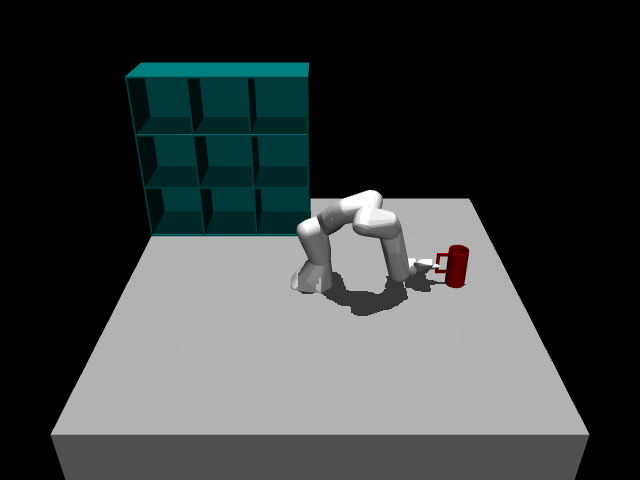

In [244]:
p_B_32 = data.xpos[mug_body_id]
quat_B_32 = data.xquat[mug_body_id]
print(p_B_32)
print(quat_B_32)

p_BG = np.array([0.6-0.1034, 0.0, 0.1])
Rmat_BG = np.array([
    [0, 0, 1],
    [0, 1, 0],
    [-1, 0, 0]
])
Rmat_GF = np.array([
    [0.707, 0.707, 0],
    [-0.707, 0.707, 0],
    [0, 0, 1]
])
Rmat_BF = Rmat_BG

joints_32 = panda_ik_31(Rmat_BF.tolist(), p_BG.tolist(), model)
## Do *not* modify the code below
set_joint_positions(model, data, joints_32)
render_state(model, data)
# ans_32 = data.qpos[7:14].tolist()


In [200]:
# p_B_32 = model.body("mug1").pos
# quat_B_32 = model.body("mug1").quat
# p_BGfloat_32 = np.array([0, 0, 0.5])
# quat_BGfloat_32 = np.empty(4) # np.array([1, 0, 0, 0]) 
# p_Gfloat_32 = np.empty(3) 
# quat_Gfloat_32 = np.empty(4)
# R = np.array([
#     [0, 1, 0],
#     [1, 0, 0],
#     [0, 0, -1]
# ])
# mujoco.mju_mat2Quat(quat_BGfloat_32, R.reshape(-1))
# mujoco.mju_mulPose(p_Gfloat_32, quat_Gfloat_32, p_B_32, quat_B_32, p_BGfloat_32, quat_BGfloat_32)

# Rmat_Gfloat_32 = np.empty(9)
# mujoco.mju_quat2Mat(Rmat_Gfloat_32, quat_Gfloat_32)
# Rmat_Gfloat_32 = Rmat_Gfloat_32.reshape(3,3)

# joints_32 = panda_ik_31(Rmat_Gfloat_32.tolist(), p_Gfloat_32.tolist(), model)

# ## Do *not* modify the code below
# set_joint_positions(model, data, joints_32)
# render_state(model, data)
# ans_32 = data.qpos[7:14].tolist()

0.0


""

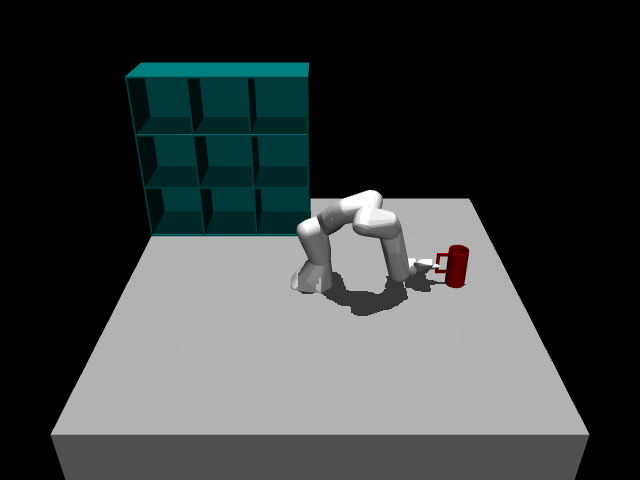

In [249]:
finger1_act_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "panda_finger_joint1_ctrl")
finger2_act_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, "panda_finger_joint2_ctrl")

# data.qpos[14:16] = [0.0, 0.0]
data.ctrl[finger1_act_id] = 0.00
data.ctrl[finger2_act_id] = 0.00
force = data.actuator_force[finger1_act_id]
print(force)
render_state(model, data)

In [250]:
# p_GfloatGpick_33 = np.array([0, 0, 0.38])
# quat_GfloatGpick_33 = np.array([1, 0, 0, 0])
# p_Gpick_33 = np.empty(3)
# quat_Gpick_33 = np.empty(4)
# mujoco.mju_mulPose(p_Gpick_33, quat_Gpick_33, p_Gfloat_32, quat_Gfloat_32, p_GfloatGpick_33, quat_GfloatGpick_33)

# Rmat_Gpick33 = np.empty(9)
# mujoco.mju_quat2Mat(Rmat_Gpick33, quat_Gpick_33)
# Rmat_Gpick33 = Rmat_Gpick33.reshape(3,3)

# # print(quat_Gpick_33)
# joints_33 = panda_ik_31(Rmat_Gpick33.tolist(), p_Gpick_33.tolist(), model)

# ## Do *not* modify the code below
# set_joint_positions(model, data, joints_33)
# render_state(model, data)
# ans_33 = data.qpos[7:14].tolist()

In [251]:
for i in range(data.ncon):
    contact = data.contact[i]
    geom1_id = contact.geom1
    geom2_id = contact.geom2

    geom1_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_GEOM, geom1_id)
    geom2_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_GEOM, geom2_id)
    print(f"Contact between {geom1_name} and {geom2_name}")

    # if ('finger' in geom1_name and 'mug' in geom2_name) or ('finger' in geom2_name and 'mug' in geom1_name) or ('hand' in geom1_name and 'mug' in geom2_name):
    #     print("Grasp contact detected!")


# for i in range(data.ncon):
#     contact = data.contact[i]
#     geom1_id = contact.geom1
#     geom2_id = contact.geom2

#     geom1_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_GEOM, geom1_id)
#     geom2_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_GEOM, geom2_id)
#     contact_force = contact.friction[0]  # Adjust based on how forces are represented
#     print(f"Contact between {geom1_name} and {geom2_name}, force: {contact_force}")


Contact between table_collision and panda_link0_collision
Contact between table_collision and mug1_collision
Contact between panda_leftfinger_collision and panda_rightfinger_collision
Contact between panda_leftfinger_collision and mug1_collision
Contact between panda_rightfinger_collision and mug1_collision
